gaussian
linear
periodic


C:\Users\sy\AppData\Local\Temp\ipykernel_10392\508552406.py:73: RuntimeWarning: covariance is not positive-semidefinite.
  return mvnrand (np.zeros(N), K)


exponential
matern3
matern5


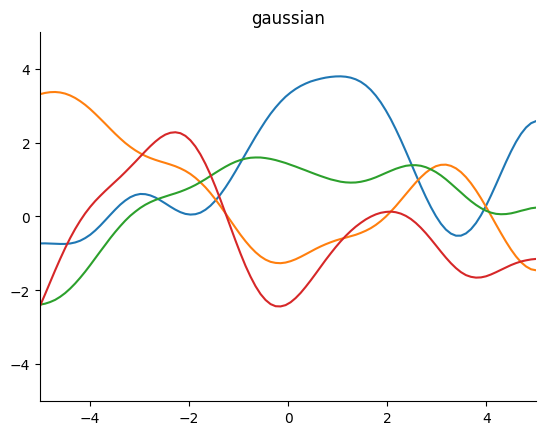

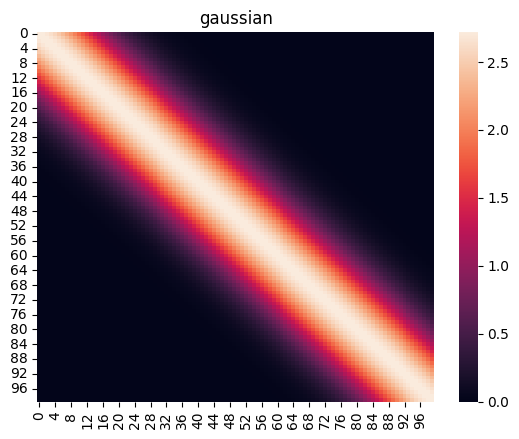

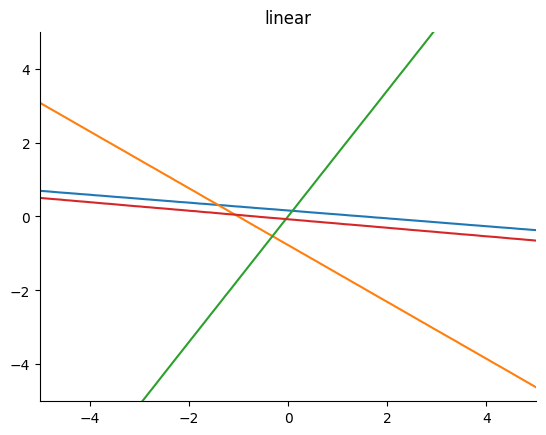

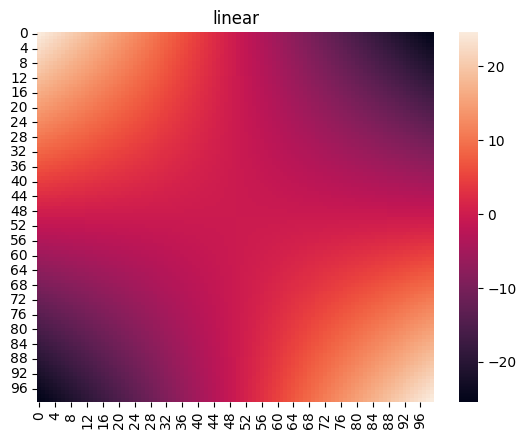

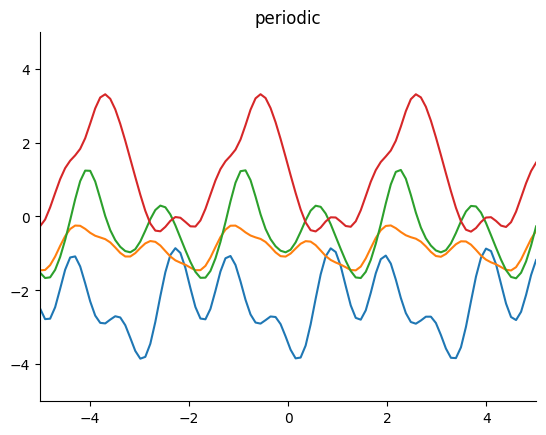

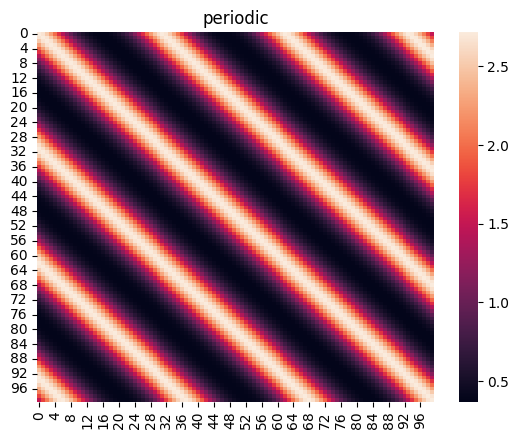

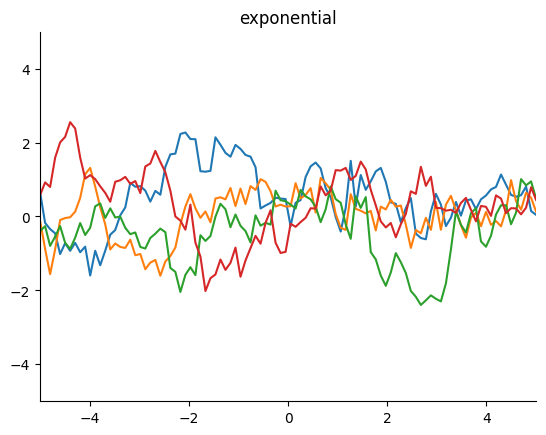

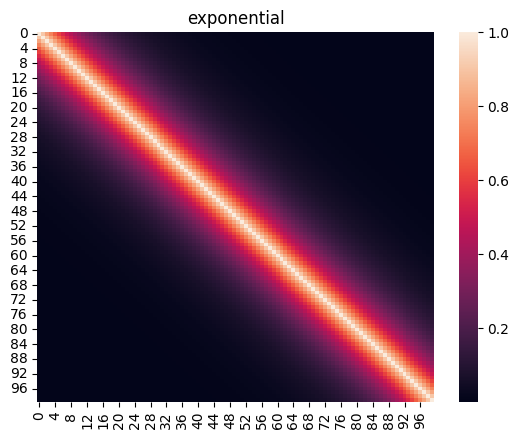

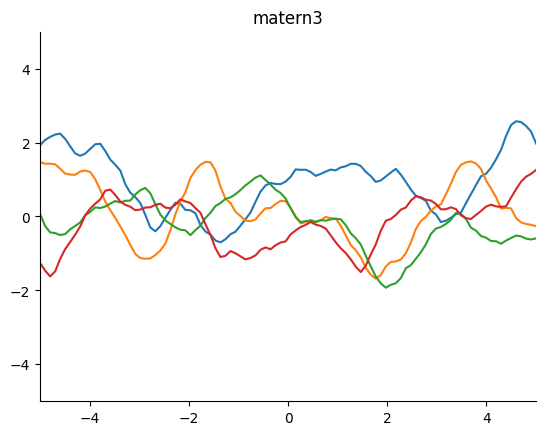

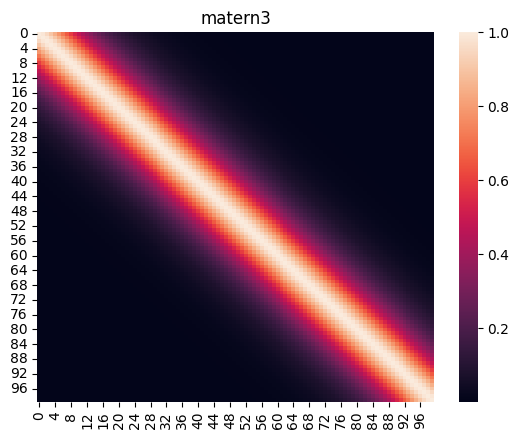

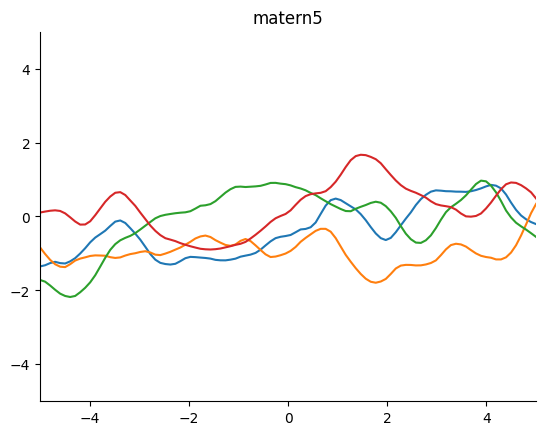

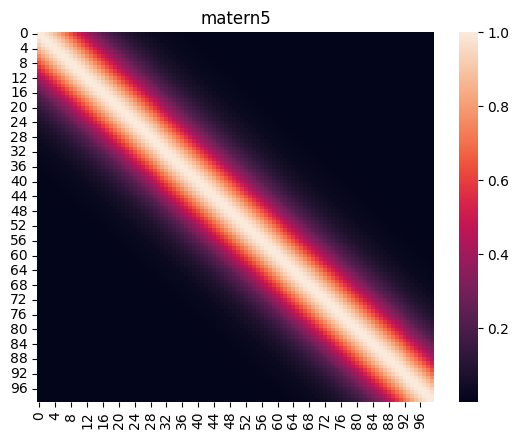

In [1]:
# Fig. 3.11 kernel.py

import library.putil as putil
import numpy as np
from numpy.random import multivariate_normal as mvnrand
import matplotlib.pyplot as plt
import seaborn as sns

xmax = 5
xmin = -5
ymax = 5
ymin = -5
M    = 4
N    = 100

SAVE_FILE = ""

def let (val, func):
    return func(val)

# (3.37), (P.75)
def klinear ():
    # Usually, x should be (b, x) = (b, x1, x2, ..., xn)
    b = np.random.randn()
    return lambda x,y: b + x * y

# (3.38)
def kexp (sigma = 1.0):
    return lambda x,y: np.exp (- np.abs(x - y) / sigma)

# (3.26)
def kgauss (params = (1.0, 1.0)):
    [tau,sigma] = params
    # theta 1 = exp(tau), theta 2 = exp(sigma)
    return lambda x,y: np.exp(tau) * np.exp (-(x - y)**2 / np.exp(sigma))

# (3.39)
def kperiodic (params = (1.0, 0.5)):
    [tau,sigma] = params
    # theta 1 = tau, theta 2 = sigma
    return lambda x,y: np.exp (tau * np.cos ((x - y) / sigma))
#    return lambda x,y: np.exp (tau * np.cos (np.abs(x - y) / sigma))

def kmatern3 (sigma = 1.0):
    # (3.51). nu is 3/2, refer (3.50) for r
    # theta is sigma
    return lambda x,y: \
        let (abs(x - y), lambda r:
             (1 + np.sqrt(3) * r / sigma) * np.exp (- np.sqrt(3) * r / sigma))

def kmatern5 (sigma = 1.0):
    # (3.51). nu is 3/2, refer (3.50) for r
    # theta is sigma
    return lambda x,y: \
        let (abs(x - y), lambda r:
             (1 + np.sqrt(5) * r / sigma + 5 * r * r / (3 * sigma * sigma))
             * np.exp (- np.sqrt(5) * r / sigma))

def kernel_matrix (xx, kernel):
    N = len(xx)
    eta = 1e-6
    # Return K
    # small offset for stability
    # Also refer to (3.58)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def fgp (xx, kernel):
    N = len(xx)
    K = kernel_matrix (xx, kernel)
    # Draw all data at the same time
    return mvnrand (np.zeros(N), K)

def fgpGetK(xx, kernel):
    K = kernel_matrix (xx, kernel)

    return K

def plotKernel(kernelName, kernelFunc):
    xx = np.linspace (xmin, xmax, N)

    fig = plt.figure()
    ax = fig.add_subplot()

    print(kernelName)
    for m in range(M):
        plt.plot (xx, fgp (xx, kernelFunc()))

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(kernelName)

    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(fgpGetK (xx, kernelFunc()))
    ax.set_title(kernelName)

#    if kernelName == 'periodic':
#        K = fgpGetK (xx, kernelFunc())
#        print(K)
#        print(np.linalg.eig(K))

def main ():
    kernelName = ['gaussian', 'linear', 'periodic', 'exponential', 'matern3', 'matern5']
    kernelFunc = [kgauss, klinear, kperiodic, kexp, kmatern3, kmatern5]

    for kName, kFunc in zip(kernelName, kernelFunc):
        plotKernel(kName, kFunc)

    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

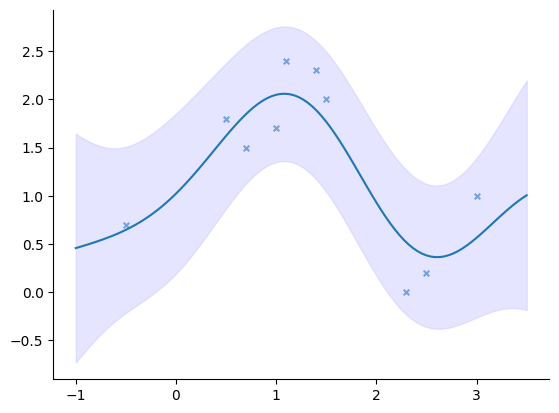

In [2]:
# Fig. 3.16 gpr-simple.py
import library.putil as putil
import numpy as np
from numpy import exp,sqrt
from numpy.linalg import inv

DATA_FILE = "data/gpr.dat"
SAVE_FILE = ""

# plot parameters
N    = 100
xmin = -1
xmax = 3.5
ymin = -1
ymax = 3

# GP kernel parameters
# (3.59)
# If eta is small, y* fits all points. spr will be small. 
eta   = 0.1
#eta   = 1e-6
tau   = 1
sigma = 1

# (3.26)
def kgauss (params = (1.0, 1.0)):
    [tau,sigma] = params
    return lambda x,y: tau * exp (-(x - y)**2 / (2 * sigma * sigma))

# (3.68)
def kv (x, xtrain, kernel):
    return np.array ([kernel(x,xi) for xi in xtrain])

# (3.15), (3.63)
def kernel_matrix (xx, kernel):
    N = len(xx)
    
    # (3.59)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def gpr (xx, xtrain, ytrain, kernel):
    # Calculate (3.74)
    # K does not depend on x
    # The dimension of K is the dimension of x X the dimension of x
    K = kernel_matrix (xtrain, kernel)
    #print(xtrain)
    #print(K)

    Kinv = inv(K)
    ypr = []
    spr = []
    
    # Calculate y* and its distribution for all xs.
    for x in xx:
        # (3.69) ((3.59))
        s = kernel (x,x) + eta
        # (3.68)
        k = kv (x, xtrain, kernel)
        # Here is (3.75)
        ypr.append (k.T.dot(Kinv).dot(ytrain))
        # (3.74)
        spr.append (s - k.T.dot(Kinv).dot(k))
    return ypr, spr

def gpplot (xx, xtrain, ytrain, kernel, params):
    ypr,spr = gpr (xx, xtrain, ytrain, kernel(params))
#    ax = plt.figure().gca().axes
#    ax.set_ylim(0, 3)
    plt.scatter(xtrain, ytrain, marker = 'x', s = 16)
    plt.plot (xx, ypr)
    plt.fill_between (xx, ypr - 2*sqrt(spr), ypr + 2*sqrt(spr), color='#ccccff', alpha = 0.5)

def main ():
    train = np.loadtxt (DATA_FILE, dtype=float)
        
    xtrain = train.T[0]
    ytrain = train.T[1]
    kernel = kgauss
    params = [tau,sigma]
    xx     = np.linspace (xmin, xmax, N)

    gpplot (xx, xtrain, ytrain, kernel, params)
    
    putil.simpleaxis ()
    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    
    plt.show ()

if __name__ == "__main__":
    main ()
